___
## Libraries Imports

In [22]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

from seglearn.transform import SegmentXY, last

from tensorflow.keras.models import load_model

from sklearn.metrics import r2_score, explained_variance_score, mean_absolute_error, mean_squared_error

___
## Data Import

In [23]:
mocap = pd.read_csv('V-vs-K_data.csv')

___
## Data Formatting

In [24]:
mocap_active = mocap
right_list = ['K_RHip_x', 'K_RHip_y', 'K_RHip_z', 'K_RKnee_x', 'K_RKnee_y', 'K_RKnee_z', 'K_RAnkle_x', 'K_RAnkle_y', 'K_RAnkle_z',
                     'V_RHip_fl', 'V_RKnee_fl', 'V_RKnee_ab', 'K_RHip_fl', 'K_RKnee_fl', 'K_RKnee_ab']
left_list = ['K_LHip_x', 'K_LHip_y', 'K_LHip_z', 'K_LKnee_x', 'K_LKnee_y', 'K_LKnee_z', 'K_LAnkle_x', 'K_LAnkle_y', 'K_LAnkle_z',
                    'V_LHip_fl', 'V_LKnee_fl', 'V_LKnee_ab', 'K_LHip_fl', 'K_LKnee_fl', 'K_LKnee_ab']
mocap_active[right_list] = mocap[right_list].mask(mocap['trial_cat']=='LDist')
mocap_active[left_list] = mocap[left_list].mask(mocap['trial_cat']=='RDist')
mocap_active[right_list] = mocap[right_list].mask(mocap['trial_cat']=='LTimed')
mocap_active[left_list] = mocap[left_list].mask(mocap['trial_cat']=='RTimed')

___
## Data Selection

In [25]:
input_columns_R = ['K_RHip_x', 'K_RHip_y', 'K_RHip_z', 'K_RKnee_x', 'K_RKnee_y', 'K_RKnee_z', 'K_RAnkle_x', 'K_RAnkle_y', 'K_RAnkle_z']
input_columns_L = ['K_LHip_x', 'K_LHip_y', 'K_LHip_z', 'K_LKnee_x', 'K_LKnee_y', 'K_LKnee_z', 'K_LAnkle_x', 'K_LAnkle_y', 'K_LAnkle_z']

target_columns_R = ['V_RKnee_fl', 'K_RKnee_fl']
target_columns_L = ['V_LKnee_fl', 'K_LKnee_fl']

X_R = mocap_active[['trial_id'] + input_columns_R]
X_L = mocap_active[['trial_id'] + input_columns_L]
y_R = mocap_active[['trial_id'] + target_columns_R]
y_L = mocap_active[['trial_id'] + target_columns_L]

X_R['trial_id'] = mocap_active['trial_id'].apply(lambda id: id+.01)
X_L['trial_id'] = mocap_active['trial_id'].apply(lambda id: id+.02)
y_R['trial_id'] = mocap_active['trial_id'].apply(lambda id: id+.01)
y_L['trial_id'] = mocap_active['trial_id'].apply(lambda id: id+.02)

X_L[['K_LHip_y', 'K_LKnee_y', 'K_LAnkle_y']] = X_L[['K_LHip_y', 'K_LKnee_y', 'K_LAnkle_y']]*-1

X_RL_combined_columns = ['trial_id', 'K_Hip_x', 'K_Hip_y', 'K_Hip_z', 'K_Knee_x', 'K_Knee_y', 'K_Knee_z', 'K_Ankle_x', 'K_Ankle_y', 'K_Ankle_z']
X_R.columns = X_RL_combined_columns
X_L.columns = X_RL_combined_columns

y_RL_combined_columns = ['trial_id', 'V_Knee_fl', 'K_Knee_fl']
y_R.columns = y_RL_combined_columns
y_L.columns = y_RL_combined_columns

X = pd.concat([X_R, X_L])
y = pd.concat([y_R, y_L])

original_length_X = len(X)
original_length_y = len(X)

X = X.dropna()
y = y.dropna()

print('Percentage of dropped data:\t', np.round(100-len(X)*100/original_length_X, 2), ' %')
print('Percentage of dropped data:\t', np.round(100-len(y)*100/original_length_y, 2), ' %')

c:\users\bdour\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
c:\users\bdour\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]
c:\users\bdour\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col

Percentage of dropped data:	 41.88  %
Percentage of dropped data:	 41.88  %


___
## Train/Validation split

In [26]:
val_size = 0.2

n_unique_trials = X['trial_id'].nunique()
n_train_trials = int(n_unique_trials*(1-val_size))
n_val_trials = int(n_unique_trials*val_size)

print('Validation size:\t\t', int(val_size*100), '%')
print('Total number of trials:\t\t', X['trial_id'].nunique())
print('Number of training trials:\t', n_train_trials)
print('Number of validation trials:\t', n_val_trials)

id_list = X['trial_id'].unique()

np.random.seed(101)
np.random.shuffle(id_list)

id_list_train = id_list[:n_train_trials]
id_list_val = id_list[n_train_trials:]

X_train = X[X['trial_id'].isin(id_list_train)]
X_val = X[X['trial_id'].isin(id_list_val)]
y_train = y[y['trial_id'].isin(id_list_train)]
y_val = y[y['trial_id'].isin(id_list_val)]

Validation size:		 20 %
Total number of trials:		 439
Number of training trials:	 351
Number of validation trials:	 87


___
## Data Segmentation

In [27]:
step_size = 1
segmentation_width = 10

X_train = X_train.values
y_train = y_train.values
X_val = X_val.values
y_val = y_val.values

# Initialization
X_train_trials_list = []
y_train_trials_list = []
y_train_trials_id_list = []
X_val_trials_list = []
y_val_trials_list = []
y_val_trials_id_list = []

# Isolate each unique trial data as a numpy array and append it to the trials list
for i in np.unique(X_train[:,0]): 
    Xi = X_train[X_train[:,0] == i, 1:]
    X_train_trials_list.append(Xi)
    yi = y_train[y_train[:,0] == i, 1:]
    y_train_trials_list.append(yi)
    idi = y_train[y_train[:,0] == i, 0]
    y_train_trials_id_list.append(idi)
    if len(Xi) != len(yi):
        raise ValueError("Different lengths between X ", len(Xi), " and y ", len(yi), " for trial ID: ", i)

for i in np.unique(X_val[:,0]): 
    Xi = X_val[X_val[:,0] == i, 1:]
    X_val_trials_list.append(Xi)
    yi = y_val[y_val[:,0] == i, 1:]
    y_val_trials_list.append(yi)
    idi = y_val[y_val[:,0] == i, 0]
    y_val_trials_id_list.append(idi)
    if len(Xi) != len(yi):
        raise ValueError("Different lengths between X ", len(Xi), " and y ", len(yi), " for trial ID: ", i)
        
train_trials_length = [len(x) for x in X_train_trials_list]
val_trials_length = [len(x) for x in X_val_trials_list]

X_train_trials_array = np.array(X_train_trials_list)
y_train_trials_array = np.array(y_train_trials_list)
y_train_trials_id_array = np.array(y_train_trials_id_list)
X_val_trials_array = np.array(X_val_trials_list)
y_val_trials_array = np.array(y_val_trials_list)
y_val_trials_id_array = np.array(y_val_trials_id_list)

y_train_trials_array_target = np.array([y_train_trials_array[:][x][:,0] for x in range(len(y_train_trials_array))])
y_train_trials_array_kinect = np.array([y_train_trials_array[:][x][:,1] for x in range(len(y_train_trials_array))])
y_val_trials_array_target = np.array([y_val_trials_array[:][x][:,0] for x in range(len(y_val_trials_array))])
y_val_trials_array_kinect = np.array([y_val_trials_array[:][x][:,1] for x in range(len(y_val_trials_array))])

seg = SegmentXY(step=step_size, width=segmentation_width, order='C', y_func=last)

X_train, y_train, _ = seg.transform(X_train_trials_array, y_train_trials_array_target)
_, y_train_kinect, _ = seg.transform(X_train_trials_array, y_train_trials_array_kinect)
_, y_train_id, _ = seg.transform(X_train_trials_array, y_train_trials_id_array)
X_val, y_val, _ = seg.transform(X_val_trials_array, y_val_trials_array_target)
_, y_val_kinect, _ = seg.transform(X_val_trials_array, y_val_trials_array_kinect)
_, y_val_id, _ = seg.transform(X_val_trials_array, y_val_trials_id_array)

print('TRAINING DATA')
print('Number of segments:\t\t', X_train.shape[0])
print('Percentage of the dataset:\t', np.round(X_train.shape[0]*100/(X_train.shape[0]+X_val.shape[0]),2), '%')
print('Segments width:\t\t\t', X_train.shape[1])
print('Number of input channels:\t', X_train.shape[2])
print('\n')
print('VALIDATION DATA')
print('Number of segments:\t\t', X_val.shape[0])
print('Percentage of the dataset:\t', np.round(X_val.shape[0]*100/(X_train.shape[0]+X_val.shape[0]),2), '%')
print('Segments width:\t\t\t', X_val.shape[1])
print('Number of input channels:\t', X_val.shape[2])

TRAINING DATA
Number of segments:		 40527
Percentage of the dataset:	 79.08 %
Segments width:			 10
Number of input channels:	 9


VALIDATION DATA
Number of segments:		 10722
Percentage of the dataset:	 20.92 %
Segments width:			 10
Number of input channels:	 9


___
## Load Model

In [28]:
model = load_model('trained-models/Knee_fl_active.h5')

___
## Generate Predictions

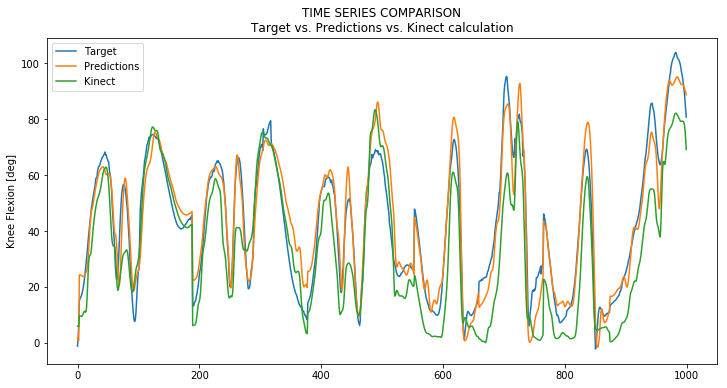

In [29]:
predictions = model.predict(X_val)

sample_size = 1000
start_idx = int(np.random.randint(0, len(y_val)-sample_size, 1))
end_idx = int(start_idx + sample_size)

plt.figure(figsize=(12,6))
plt.plot(y_val[start_idx:end_idx], label='Target')
plt.plot(predictions[start_idx:end_idx], label='Predictions')
plt.plot(y_val_kinect[start_idx:end_idx], label='Kinect')
plt.ylabel('Knee Flexion [deg]')
plt.title('TIME SERIES COMPARISON\nTarget vs. Predictions vs. Kinect calculation')
plt.legend()
plt.show()

___
## Model Evaluation

In [30]:
def ICC_2way_mixed(data):
    '''
    Calculate the Intraclass Correlation Coefficient (ICC) using the Two-way Mixed Model for Case 3* defined by Patrick E. Shrout and Joseph L. Fleiss. “Intraclass Correlations: Uses in assessing rater reliability.” Psychological Bulletin 86.2 (2979): 420-428
        *In Case 3, each target/subject/observation is rated by each of the same m observers/judges/methods, who are the only observers/judges/methods of interest.
    Input:
        data: mxn array where m is the number of rows (each row is a measurement/observation/subject) and where n is the number of observers/judges/methods.
    Output:
        ICC: intraclass correlation coeeficient (3,1)
        df_m: number of degrees of freedom (df) between observers/judges/methods
        df_n: number of degrees of freedom (df) between measurements/observations/subjects
        F_stat: F-Statistic - session effect (calculated as the ratio between the vartiation between sample means and the variation within samples - i.e. ratio of two quantities that are expected to be roughly equal under the null hypothesis)
        var_obs: variance between measurements/observations/subjects
        MSE: mean squared error (calculated as the sum of squared error divided by the number of degrees of freedom between measurements/observations/subjects: SSE/df_n)
    Dependencies:
        None
    '''

    # Compute data shape and degrees of freedom
    [num_n, num_m] = data.shape
    df_m = num_m - 1
    df_n0 = num_n - 1
    df_n = df_n0 * df_m

    # Compute the sum of distance to the mean
    mean_data = np.mean(data)
    sum_dist_mean = ((data - mean_data)**2).sum()

    # Create the design matrix for the different levels
    x = np.kron(np.eye(num_m), np.ones((num_n, 1)))
    x0 = np.tile(np.eye(num_n), (num_m, 1))
    X = np.hstack([x, x0])

    # Computer the Sum of Squared Error
    predicted_data = np.dot(np.dot(np.dot(X, np.linalg.pinv(np.dot(X.T, X))), X.T), data.flatten('F'))
    residuals = data.flatten('F') - predicted_data
    SSE = (residuals**2).sum()
    residuals.shape = data.shape

    # Compute the Mean Squared Error (MSE)
    MSE = SSE / df_n

    # Compute the F-statistic (session effect) - between observers/judges/methods (columns)
    SSC = ((np.mean(data, 0) - mean_data)**2).sum() * num_n
    MSC = SSC / df_m / num_n
    F_stat = MSC / MSE

    # Computer the subject effect - between measurements/observations/subjects (rows)
    SSR = sum_dist_mean - SSC - SSE
    MSR = SSR / df_n0

    # Compute variance between subjects
    var_obs = (MSR - MSE) / num_m

    # Computer ICC(3,1)
    ICC = (MSR - MSE) / (MSR + df_m * MSE)

    return ICC, df_m, df_n, F_stat, var_obs, MSE

In [31]:
y_train_id_list, y_train_id_idx = np.unique(y_train_id, return_index=True)
y_val_id_list, y_val_id_idx = np.unique(y_val_id, return_index=True)

val_target_peak, val_predic_peak, val_kinect_peak = [], [], []

for i in y_val_id_idx[:len(y_val_id_idx)]:
    target_peaki = np.max(y_val[i:i+1])
    predic_peaki = np.max(predictions[i:i+1])
    kinect_peaki = np.max(y_val_kinect[i:i+1])
    val_target_peak.append(target_peaki)    
    val_predic_peak.append(predic_peaki)
    val_kinect_peak.append(kinect_peaki)
val_ICC_predict, _, _, _, _, _ = ICC_2way_mixed(np.transpose([val_target_peak, val_predic_peak]))
val_ICC_kinect, _, _, _, _, _ = ICC_2way_mixed(np.transpose([val_target_peak, val_kinect_peak]))

print('MODEL EVALUATION REPORT')
print('\n')
print('Target vs. Model Predictions')
print('\tR2 score:\t\t\t\t', np.round(100*r2_score(y_val, predictions),2), '\t%')
print('\tExplained variance score:\t\t', np.round(100*explained_variance_score(y_val, predictions),2), '\t%')
print('\tMean absolute error:\t\t\t', np.round(mean_absolute_error(y_val, predictions),2), '\tdeg')
print('\tMean squared error:\t\t\t', np.round(mean_squared_error(y_val, predictions),2), 'deg2')
print('\tRoot mean squared error:\t\t', np.round(np.sqrt(mean_squared_error(y_val, predictions)),2), '\tdeg')
print('\tRelative root mean squared error:\t', np.round(np.sqrt(mean_squared_error(y_val, predictions))*100/(np.max(y_val)-np.min(y_val)),2), '\t% [of the target range]')
print('\n')
print('\tICC on peak flexion angles:\t\t', np.round(val_ICC_predict,3))
print('\n')
print('Target vs. Kinect Calculation')
print('\tR2 score:\t\t\t\t', np.round(100*r2_score(y_val, y_val_kinect),2), '\t%')
print('\tExplained variance score:\t\t', np.round(100*explained_variance_score(y_val, y_val_kinect),2), '\t%')
print('\tMean absolute error:\t\t\t', np.round(mean_absolute_error(y_val, y_val_kinect),2), '\tdeg')
print('\tMean squared error:\t\t\t', np.round(mean_squared_error(y_val, y_val_kinect),2), 'deg2')
print('\tRoot mean squared error:\t\t', np.round(np.sqrt(mean_squared_error(y_val, y_val_kinect)),2), '\tdeg')
print('\tRelative root mean squared error:\t', np.round(np.sqrt(mean_squared_error(y_val, y_val_kinect))*100/(np.max(y_val)-np.min(y_val)),2), '\t% [of the target range]')
print('\n')
print('\tICC on peak flexion angles:\t\t', np.round(val_ICC_kinect,3))

MODEL EVALUATION REPORT


Target vs. Model Predictions
	R2 score:				 87.57 	%
	Explained variance score:		 87.75 	%
	Mean absolute error:			 6.24 	deg
	Mean squared error:			 66.23 deg2
	Root mean squared error:		 8.14 	deg
	Relative root mean squared error:	 6.37 	% [of the target range]


	ICC on peak flexion angles:		 0.9


Target vs. Kinect Calculation
	R2 score:				 49.38 	%
	Explained variance score:		 77.04 	%
	Mean absolute error:			 13.75 	deg
	Mean squared error:			 269.66 deg2
	Root mean squared error:		 16.42 	deg
	Relative root mean squared error:	 12.86 	% [of the target range]


	ICC on peak flexion angles:		 0.879
